In [1]:
import csv
import datetime
import itertools
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn

import numpy as np
import pandas as pd
from sklearn.decomposition import KernelPCA, SparsePCA
from sklearn.manifold import TSNE, SpectralEmbedding

import re
from nltk.tokenize import word_tokenize
from gensim.models import fasttext
from gensim.models.keyedvectors import KeyedVectors

%matplotlib inline

In [ ]:
%cd ..
# Hanseul/에서 나가기

## Opening the data files

In [2]:
path_train = "./train.csv"
path_valid_class_que = "./validation_classification_question.csv"
path_valid_class_ans = "./validation_classification_answer.csv"
path_valid_compl_que = "./validation_completion_question.csv"
path_valid_compl_ans = "./validation_completion_answer.csv"
path_test_class_que = "./test_classification_question.csv"
path_test_compl_que = "./test_completion_question.csv"
path_ingredient_name = "./node_ingredient.txt"

In [3]:
def read_train_data(path):
    """ Read train.csv and Return lists of data[int] / label[str]. """
    data = []
    labels = []
    with open(path, 'r') as f:
        for line in csv.reader(f):
            recipe = sorted(map(int, line[:-1]))  # a sorted list of recipe (integer)
            cuisine = line[-1]                    # which country? (string)
            data.append(recipe)
            labels.append(cuisine)
    return data, labels


def read_classification_data(question_path, answer_path=None):
    """ Read valid/test data for classification. Then return lists of data[int] / label[str]. """
    data = []
    labels = [] if answer_path is not None else None
    with open(question_path, 'r') as f:
        for line in csv.reader(f):
            recipe = sorted(map(int, line))  # a sorted list of recipe (integer)
            data.append(recipe)
    if answer_path is not None:
        with open(answer_path, 'r') as f:
            for line in csv.reader(f):
                cuisine = line[0]            # which country? (string)
                labels.append(cuisine)
    return data, labels


def read_completion_data(question_path, answer_path=None):
    """ Read valid/test data for completion. Then return lists of data[int] / label[str]. """
    data = []
    labels = [] if answer_path is not None else None
    with open(question_path, 'r') as f:
        for line in csv.reader(f):
            recipe = sorted(map(int, line))                # recipe without an ingredient
            data.append(recipe)
    if answer_path is not None:
        with open(answer_path, 'r') as f:
            for line in csv.reader(f):
                recipe = set(map(int, line))               # original recipe
                missing = recipe - set(data[len(labels)])  # missing ingredient in data
                labels.append(list(missing)[0])
    return data, labels


def ingredient_index_to_name(ingredient_path):
    ingredients_names = []
    with open(ingredient_path, 'r') as f:
        for line in csv.reader(f):
            ingredients_names.append(line[0])
    return ingredients_names

In [4]:
data_train, labels_train = read_train_data(path_train)
data_valid_class, labels_valid_class = read_classification_data(path_valid_class_que, path_valid_class_ans)
data_valid_compl, labels_valid_compl = read_completion_data(path_valid_compl_que, path_valid_compl_ans)
data_test_class, _ = read_classification_data(path_test_class_que, None)
data_test_compl, _ = read_completion_data(path_test_compl_que, None)
ingredient_names = ingredient_index_to_name(path_ingredient_name)

#### Train, Valid, Test data에 대한 정보!

In [14]:
_n = 3  # 예시 보여주는 개수

# train data & labels 
print('train data length:', len(labels_train))
print('train:', list(zip(data_train, labels_train))[:_n], '...\n')
print('Each recipe(=row) has at most', max(map(len, data_train)), 'ingredients!\n')

# valid classification data & labels
print('valid data length:', len(labels_valid_class))
print('valid_class:', list(zip(data_valid_class, labels_valid_class))[:_n], '...\n')
# valid completion data & labels
print('valid_compl:', list(zip(data_valid_compl, labels_valid_compl))[:_n], '...\n')
# ingredients_names
print('ingredients:', ingredient_names[:_n], '...\n')

# ingredients
print('num_ingredients:', len(ingredient_names))
print('range of ingredient indices:', min(map(min, data_train)), '~', max(map(max, data_train)),'\n')
# cuisines
cuisine_names = sorted(set(labels_train+labels_valid_class))  # 알파벳 순
print('num_cuisines:', len(cuisine_names))
print('list of cuisines (cuisine_names):', cuisine_names)

train data length: 23547
train: [([2813, 3146, 3229, 3885, 4379, 4390, 5250, 5456, 6187], 'greek'), ([392, 937, 1476, 2172, 2351, 2813, 3350, 3554, 3857, 3978, 5249, 5648], 'filipino'), ([167, 937, 2124, 2945], 'indian')] ...

Each recipe(=row) has at most 59 ingredients!

valid data length: 7848
valid_class: [([59, 233, 1308, 2061, 2338, 3332, 6683], 'japanese'), ([937, 1138, 1240, 1914, 2809, 3071, 3228, 3614, 4191, 5140, 5554, 5648, 5774, 5841, 5866, 6294, 6421], 'french'), ([937, 1308, 1476, 2710, 2945, 4342, 4799, 4917], 'filipino')] ...

valid_compl: [([59, 233, 1308, 2338, 3332, 6683], 2061), ([937, 1138, 1240, 1914, 2809, 3071, 3228, 3614, 4191, 5140, 5554, 5648, 5774, 5841, 5866, 6294], 6421), ([937, 1308, 1476, 2710, 4342, 4799, 4917], 2945)] ...

ingredients: ['coca-cola', 'vegan butter', 'sourdough rolls'] ...

num_ingredients: 6714
range of ingredient indices: 0 ~ 6713 

num_cuisines: 20
list of cuisines (cuisine_names): ['brazilian', 'british', 'cajun_creole', 'chinese', 

In [17]:
# cuisine numbering by cuisine_names
# For example, brazilian -> 0, british -> 1 etc.
cuisine_index = {cuisine_names[i]: i for i in range(len(cuisine_names))}

# change the classificafication labels into numbers
y_train = np.array([cuisine_index[cuisine] for cuisine in labels_train])
print(y_train[:_n*5],"...\n")

[ 6  4  7  7 10 17  9 13  9  9 13  7 19 18 16] ...



## One hot encoding: lists of integers(ingredients) into binary vectors

In [18]:
def one_hot_encoding(data, dim):
    """ convert data(list of lists) into a 2D array of one-hot encodings. (row = recipe) """
    enc = np.zeros((len(data), dim), dtype=int)  # dim = number of ingredients (= 6714)
    for i in range(len(data)):
        recipe = data[i]
        enc[i][recipe] = 1
    return enc

In [19]:
num_ingredients = len(ingredient_names)

enc_train = one_hot_encoding(data_train, num_ingredients)
enc_valid_class = one_hot_encoding(data_valid_class, num_ingredients)
enc_valid_compl = one_hot_encoding(data_valid_compl, num_ingredients)
enc_test_class = one_hot_encoding(data_test_class, num_ingredients)
enc_test_compl = one_hot_encoding(data_test_compl, num_ingredients)

In [20]:
print(enc_train.shape)
print(enc_valid_class.shape)
print(enc_valid_compl.shape)
print(enc_test_class.shape)
print(enc_test_compl.shape)

(23547, 6714)
(7848, 6714)
(7848, 6714)
(3924, 6714)
(3924, 6714)


## PCA on one-hot encodings of training data

In [21]:
print(f"== KernelPCA START at {datetime.datetime.now()}")
kernelpca = KernelPCA(n_components=2, kernel='cosine', random_state=1, n_jobs=-1).fit_transform(enc_train)
print(f"== KernelPCA   END at {datetime.datetime.now()}")

== KernelPCA START at 2022-03-30 18:11:41.531183
== KernelPCA   END at 2022-03-30 18:14:40.162528


<AxesSubplot:xlabel='pc1', ylabel='pc2'>

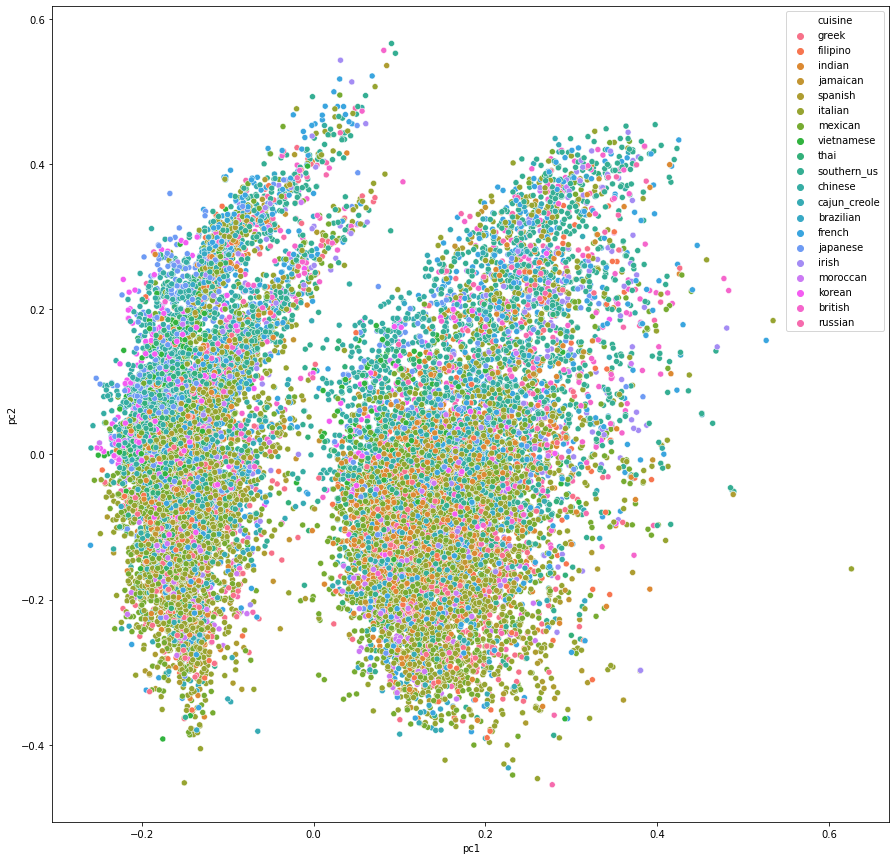

In [111]:
df = pd.DataFrame(data=kernelpca, columns=['pc1', 'pc2'])
df['cuisine'] = labels_train
plt.figure(figsize=(15,15))
seaborn.scatterplot(x='pc1', y='pc2', data=df, hue='cuisine')

In [32]:
print(f"== SparsePCA START at {datetime.datetime.now()}")
sparsepca = SparsePCA(n_components=2, random_state=1, n_jobs=-1).fit_transform(enc_train)
print(f"== SparsePCA   END at {datetime.datetime.now()}")

== SparsePCA START at 2022-03-24 19:52:27.324020
== SparsePCA   END at 2022-03-24 20:10:07.135792


<AxesSubplot:xlabel='pc1', ylabel='pc2'>

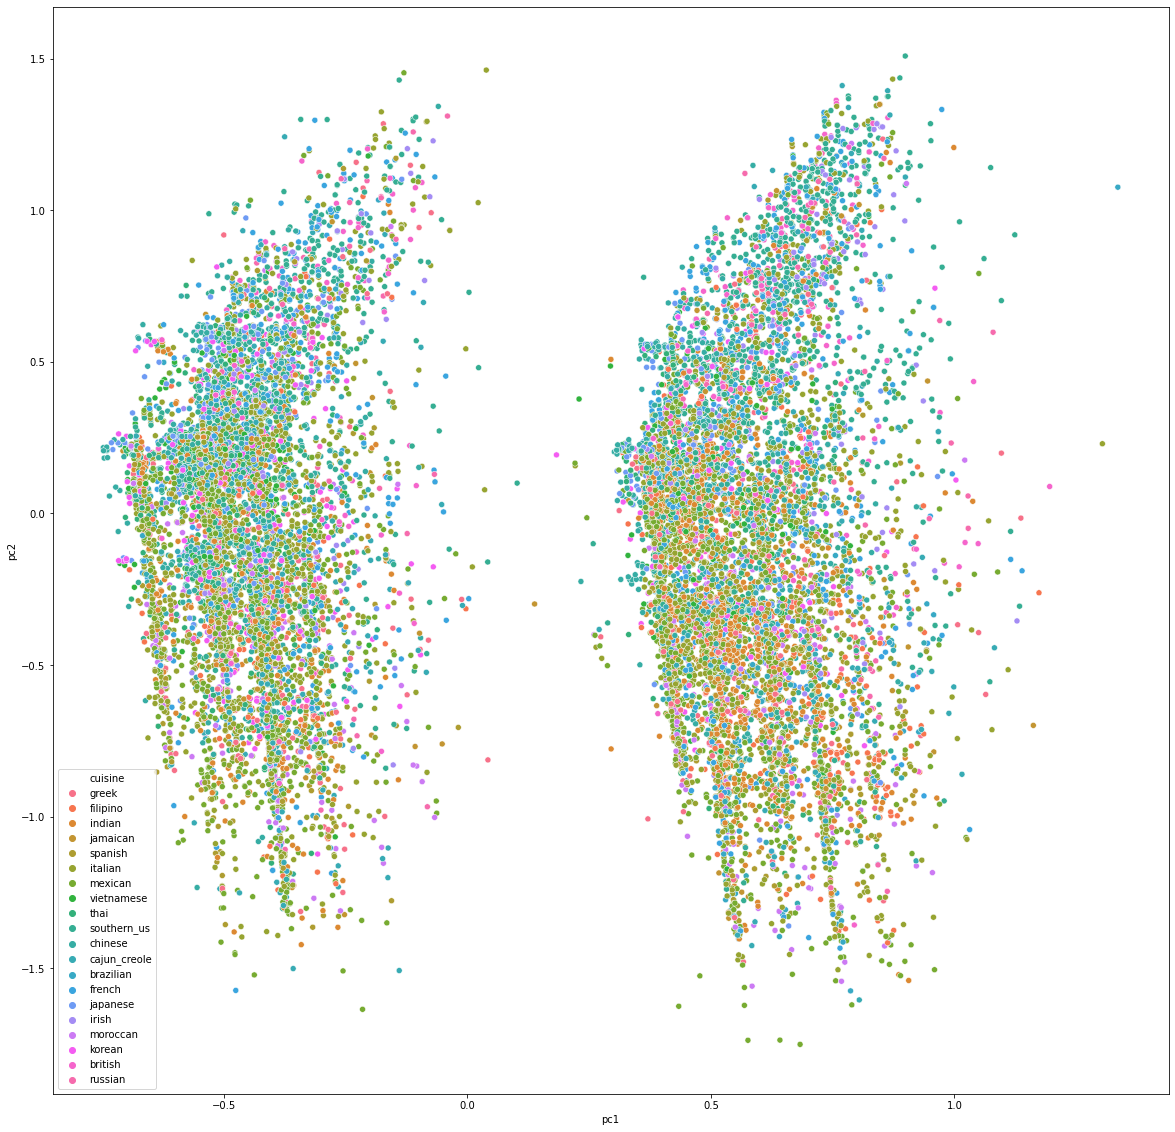

In [33]:
df = pd.DataFrame(data=sparsepca, columns=['pc1', 'pc2'])
df['cuisine'] = labels_train
plt.figure(figsize=(20,20))
seaborn.scatterplot(x='pc1', y='pc2', data=df, hue='cuisine')

## Manifold Learning on one-hot encodings of training data

In [23]:
print(f"== t-SNE START at {datetime.datetime.now()}")
tsne = TSNE(n_components=2, learning_rate='auto', init='pca', random_state=1, n_jobs=-1, n_iter=2000).fit_transform(enc_train)
print(f"== t-SNE   END at {datetime.datetime.now()}")

== t-SNE START at 2022-03-30 18:14:41.086210


/opt/homebrew/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


== t-SNE   END at 2022-03-30 18:21:34.021631


<AxesSubplot:xlabel='pc1', ylabel='pc2'>

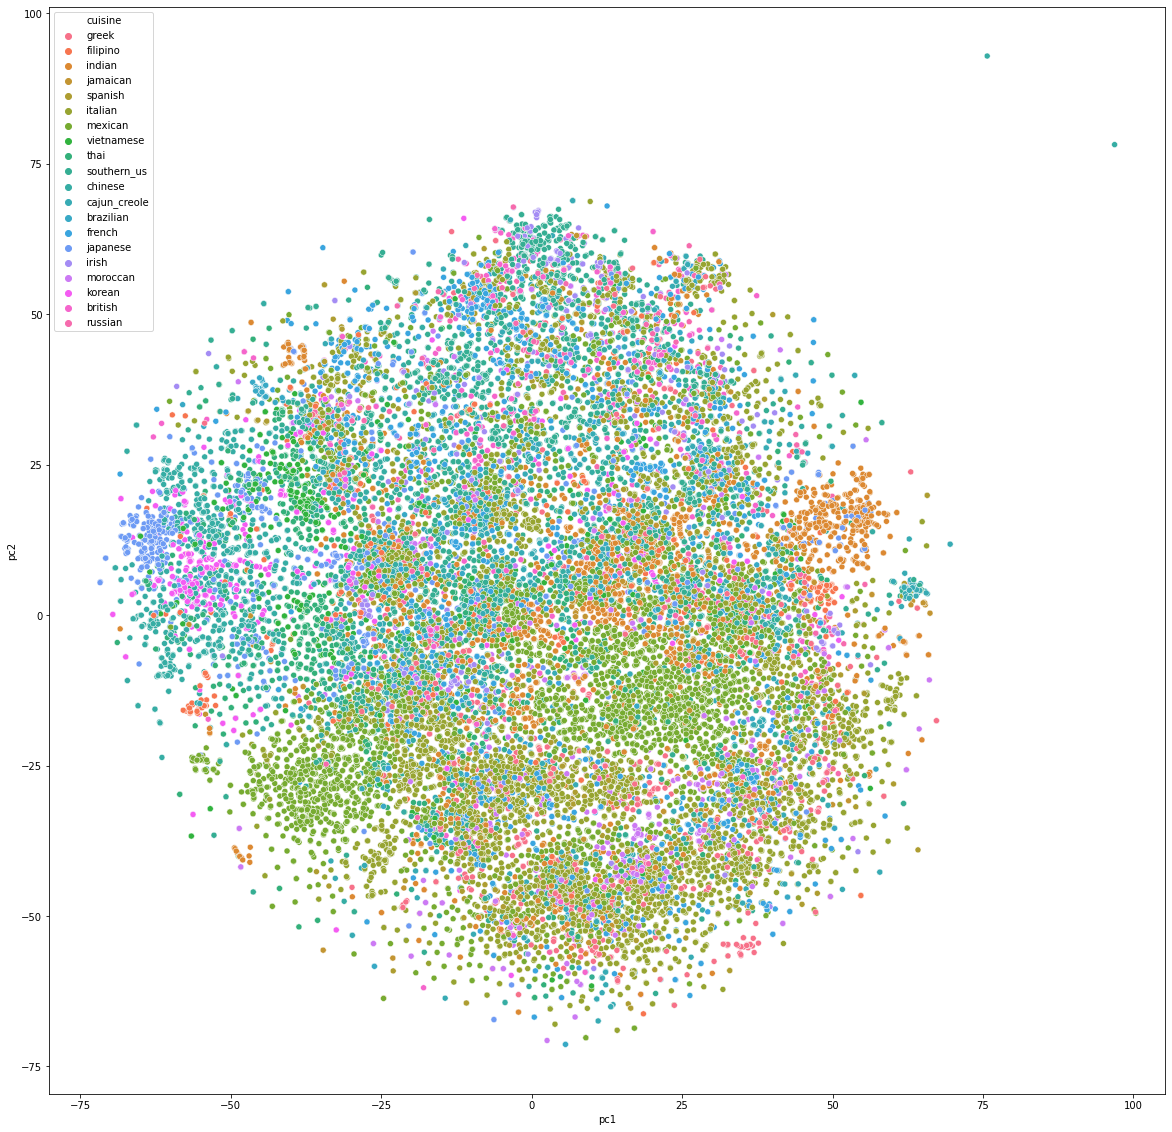

In [24]:
df = pd.DataFrame(data=tsne, columns=['pc1', 'pc2'])
df['cuisine'] = labels_train
plt.figure(figsize=(20,20))
seaborn.scatterplot(x='pc1', y='pc2', data=df, hue='cuisine')

In [42]:
print(f"== SpectralEmbedding START at {datetime.datetime.now()}")
specembed = SpectralEmbedding(n_components=2, random_state=1, n_jobs=-1).fit_transform(enc_train)
print(f"== SpectralEmbedding   END at {datetime.datetime.now()}")

== SpectralEmbedding START at 2022-03-24 20:24:13.631884
== SpectralEmbedding   END at 2022-03-24 21:46:50.691743


<AxesSubplot:xlabel='pc1', ylabel='pc2'>

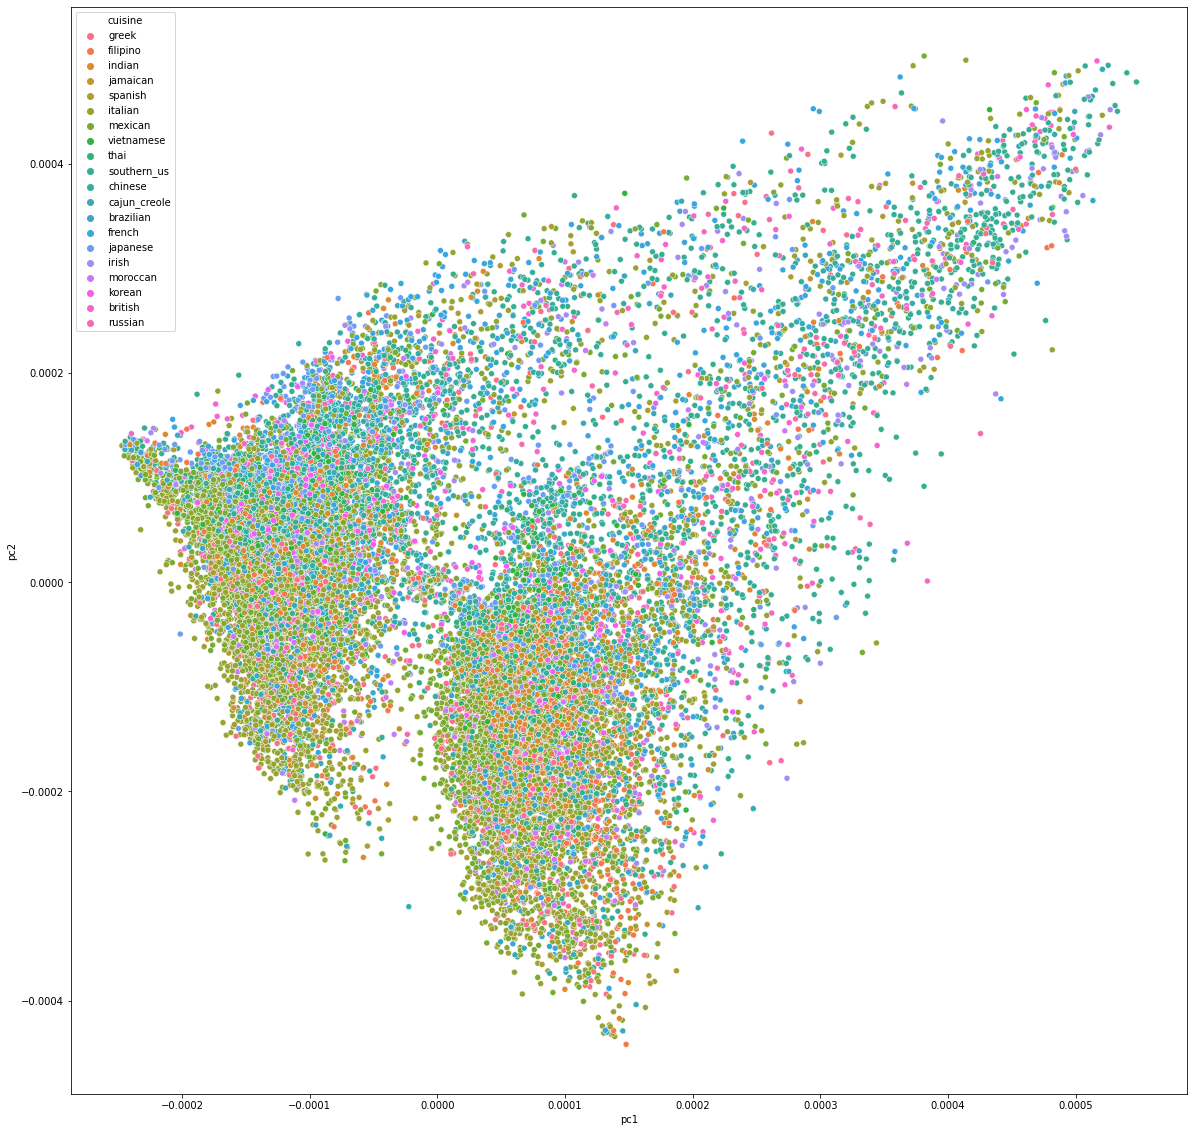

In [43]:
df = pd.DataFrame(data=specembed, columns=['pc1', 'pc2'])
df['cuisine'] = labels_train
plt.figure(figsize=(20,20))
seaborn.scatterplot(x='pc1', y='pc2', data=df, hue='cuisine')

## Tokenizing ingredient/cuisine names of multiple words

In [52]:
# tokenize ingredient names
ingredient_names_tokenized = []
for name in ingredient_names:
    tokens = re.sub(r"[^a-z0-9-_]+"," ", name.lower()).split(' ')
    ingredient_names_tokenized.append(tokens)

In [53]:
_n = 20
for name, tokens in zip(ingredient_names[:_n], ingredient_names_tokenized[:_n]):
    print(name, tokens)

coca-cola ['coca-cola']
vegan butter ['vegan', 'butter']
sourdough rolls ['sourdough', 'rolls']
reduced sodium refried beans ['reduced', 'sodium', 'refried', 'beans']
ramen noodles ['ramen', 'noodles']
crumbled corn bread ['crumbled', 'corn', 'bread']
japanese breadcrumbs ['japanese', 'breadcrumbs']
toasted shredded coconut ['toasted', 'shredded', 'coconut']
chinese spinach ['chinese', 'spinach']
Hellmann's® Real Mayonnaise ['hellmann', 's', 'real', 'mayonnaise']
ducklings ['ducklings']
basil olive oil ['basil', 'olive', 'oil']
white baking bar ['white', 'baking', 'bar']
rye whiskey ['rye', 'whiskey']
mushroom broth ['mushroom', 'broth']
meat loaf mix ['meat', 'loaf', 'mix']
cocktail sauce ['cocktail', 'sauce']
asparagus spears ['asparagus', 'spears']
nonfat greek yogurt ['nonfat', 'greek', 'yogurt']
cabernet sauvignon ['cabernet', 'sauvignon']


In [54]:
# tokenize cuisine names, for 'cajun_creole' and 'southern_us'
cuisine_names_tokenized = []
for name in cuisine_names:
    tokens = re.sub(r"[^a-z0-9-_]+"," ", name.lower()).split(' ')
    cuisine_names_tokenized.append(tokens)

In [55]:
for name, tokens in zip(cuisine_names, cuisine_names_tokenized):
    print(name, tokens)

brazilian ['brazilian']
british ['british']
cajun_creole ['cajun_creole']
chinese ['chinese']
filipino ['filipino']
french ['french']
greek ['greek']
indian ['indian']
irish ['irish']
italian ['italian']
jamaican ['jamaican']
japanese ['japanese']
korean ['korean']
mexican ['mexican']
moroccan ['moroccan']
russian ['russian']
southern_us ['southern_us']
spanish ['spanish']
thai ['thai']
vietnamese ['vietnamese']


In [59]:
all_tokens = itertools.chain(*ingredient_names_tokenized)
token_count = defaultdict(int)
for token in all_tokens:
    token_count[token] += 1

print(len(token_count), 'tokens', end='\n\n')
    
# ingredient name에 쓰인 단어 빈도수로 정렬
print(sorted(token_count.items(), key=lambda x: -x[1]))


# 

3095 tokens

[('cheese', 203), ('sauce', 198), ('chicken', 192), ('mix', 122), ('cream', 116), ('rice', 110), ('sodium', 108), ('fresh', 100), ('dried', 97), ('fat', 95), ('seasoning', 95), ('beef', 94), ('white', 93), ('whole', 92), ('pork', 90), ('red', 86), ('powder', 85), ('oil', 84), ('ground', 84), ('frozen', 83), ('bread', 82), ('beans', 81), ('flour', 80), ('juice', 80), ('pepper', 77), ('chocolate', 77), ('green', 76), ('low', 75), ('paste', 74), ('wheat', 74), ('leaves', 72), ('black', 72), ('milk', 71), ('low-fat', 71), ('italian', 71), ('reduced', 70), ('broth', 67), ('pasta', 67), ('sausage', 66), ('sugar', 63), ('soup', 61), ('tomatoes', 60), ('corn', 58), ('sweet', 58), ('butter', 57), ('shredded', 55), ('garlic', 55), ('fillets', 55), ('turkey', 54), ('hot', 53), ('salt', 53), ('stock', 53), ('chile', 51), ('dressing', 50), ('meat', 49), ('noodles', 48), ('yogurt', 48), ('chili', 48), ('bean', 48), ('coconut', 47), ('vanilla', 47), ('boneless', 47), ('vinegar', 46), ('s

## Word embedding: FastText

https://fasttext.cc

https://fasttext.cc/docs/en/crawl-vectors.html

https://fasttext.cc/docs/en/pretrained-vectors.html


To download the data, click https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.simple.zip for wiki.simple, and https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz and https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz for cc.en.300.bin & cc.en.300.vec.

In [80]:
path_model = 'wiki.simple/wiki.simple.bin' #'cc.en.300.bin'  # 또는, 'wiki.simple/wiki.simple.bin'
path_wordvector = 'wiki.simple/wiki.simple.vec' #'cc.en.300.vec'  # 또는, 'wiki.simple/wiki.simple.vec'

In [64]:
!gunzip -v cc.en.300.bin.gz
!gunzip -v cc.en.300.vec.gz

cc.en.300.bin.gz:	   37.7% -- replaced with cc.en.300.bin
cc.en.300.vec.gz:	   70.6% -- replaced with cc.en.300.vec


In [81]:
print(f"== LOAD fasttext START at {datetime.datetime.now()}")
model_fasttext = fasttext.load_facebook_model(path_model)
print(f"== LOAD fasttext   END at {datetime.datetime.now()}")

== LOAD fasttext START at 2022-03-30 20:44:33.029443
== LOAD fasttext   END at 2022-03-30 20:44:46.069395


In [112]:
# fasttext model handles out-of-vocabulary words (because the model is based on subword knowledge)
model_fasttext.wv.most_similar('coca-cola')

[('cola', 0.8341959118843079),
 ('coca', 0.7948991656303406),
 ('scola', 0.7014351487159729),
 ('arcola', 0.6920968294143677),
 ('agrícola', 0.6610180735588074),
 ('escola', 0.6575630903244019),
 ('tchecola', 0.6386056542396545),
 ('cocaine', 0.6348669528961182),
 ('rupicola', 0.6335930824279785),
 ('taccola', 0.6324460506439209)]

In [83]:
print(f"== LOAD fasttext word vectors START at {datetime.datetime.now()}")
model_fasttext2 = KeyedVectors.load_word2vec_format(path_wordvector)
print(f"== LOAD fasttext word vectors   END at {datetime.datetime.now()}")

== LOAD fasttext word vectors START at 2022-03-30 20:44:46.184165
== LOAD fasttext word vectors   END at 2022-03-30 20:44:59.989855


In [113]:
# however fasttext word vector (and any other word vectors) cannot handle out-of-vocabulary words
model_fasttext2.most_similar('coca-cola')

KeyError: "Key 'coca-cola' not present"

In [85]:
model_fasttext.wv['wiki'].shape

(300,)

In [86]:
def cosine_similarity(word1, word2):
    return model_fasttext.wv.similarity(word1, word2)

cosine_similarity('hanseul cho','hanse')

0.78997844

In [87]:
model_fasttext.wv.most_similar_cosmul(positive=['he', 'woman'], negative=['man'])

[('she', 1.0106589794158936),
 ('her', 0.9033176302909851),
 ('\xa0she', 0.8802027106285095),
 ('womanly', 0.8609711527824402),
 ('younghusband', 0.8443732261657715),
 ('his', 0.832114040851593),
 ('womans', 0.8231985569000244),
 ('herself', 0.8156289458274841),
 ('chairwoman', 0.8143290281295776),
 ('spokeswoman', 0.8135604858398438)]